In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Generator Model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(100,), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(28*28*1, use_bias=False, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

# Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(256, use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Loss function for the generator
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

11490434/11490434 [==============================] - 0s 0us/step


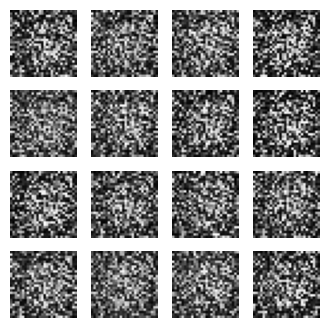

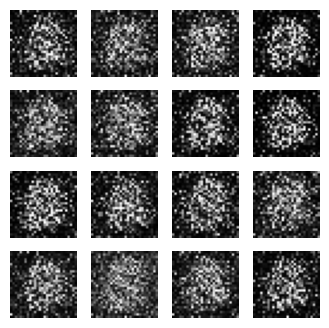

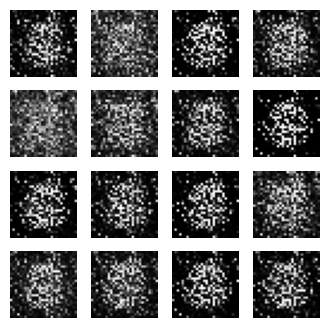

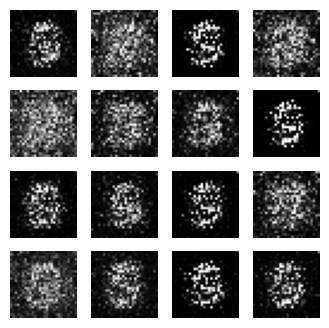

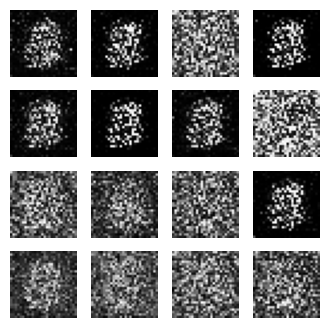

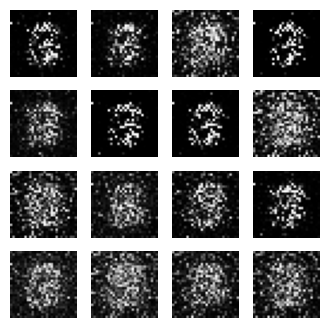

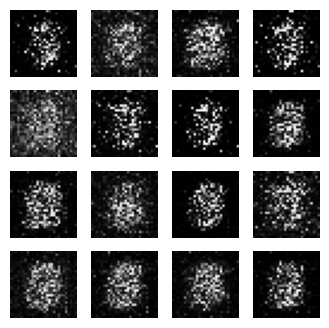

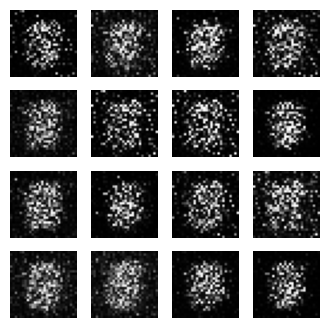

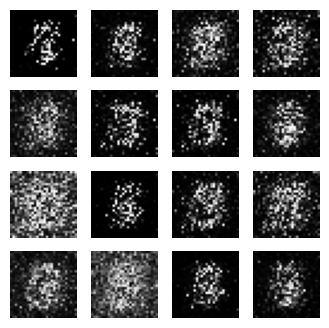

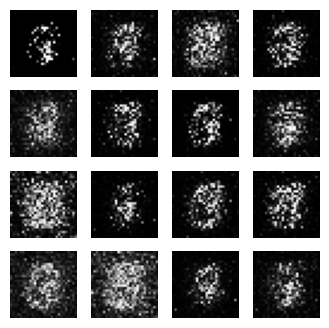

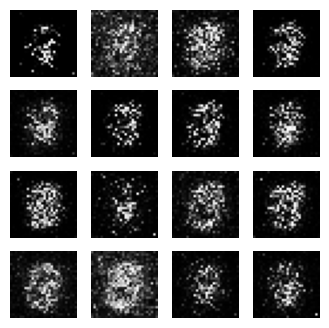

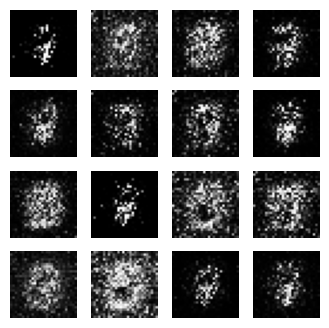

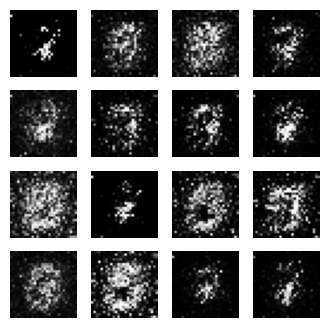

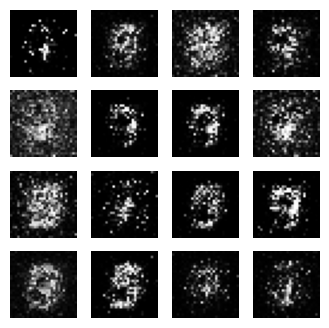

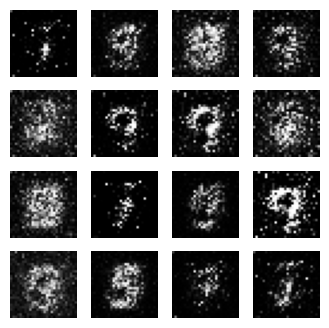

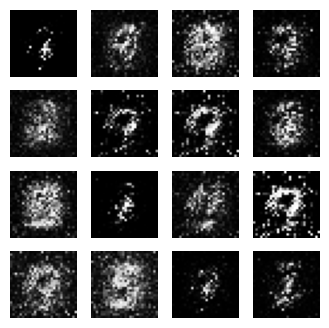

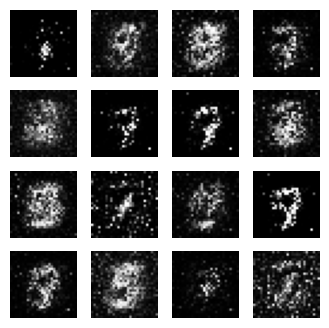

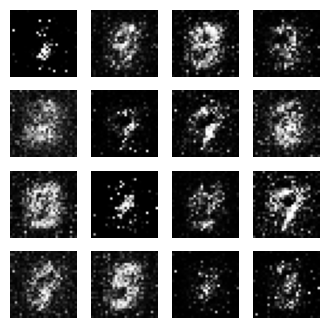

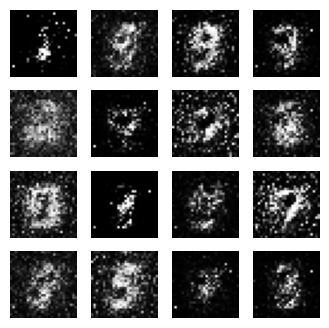

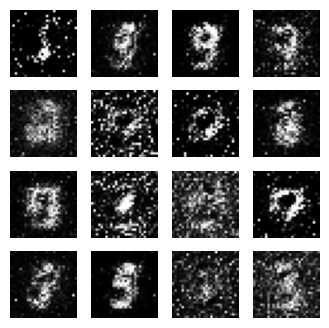

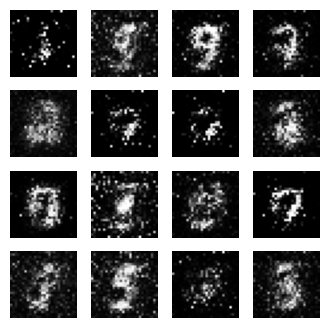

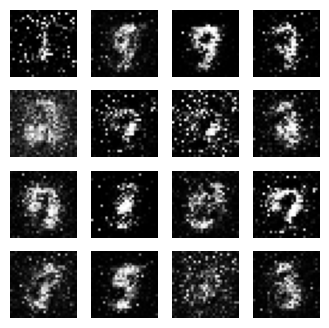

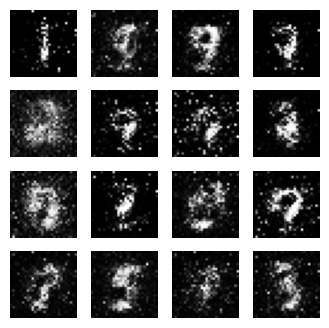

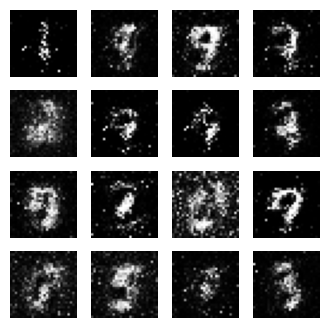

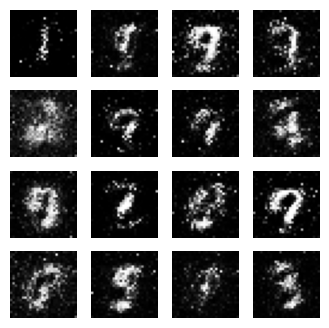

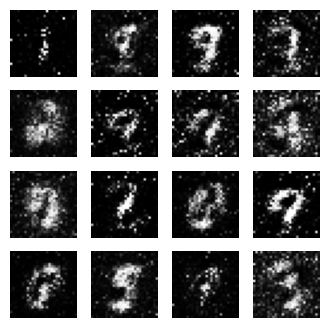

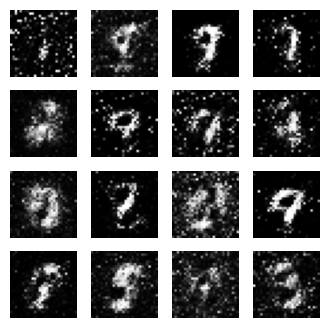

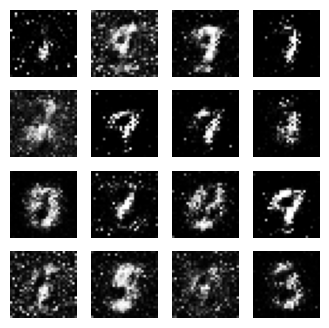

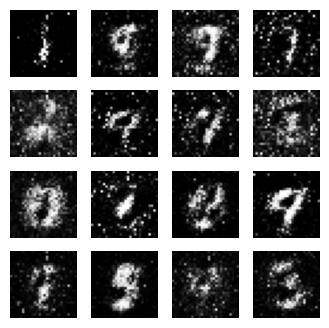

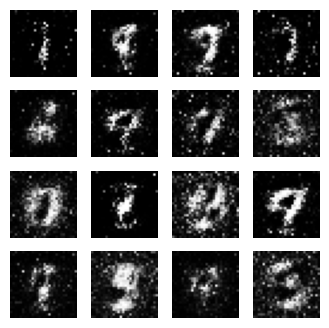

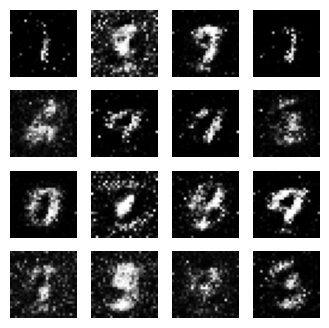

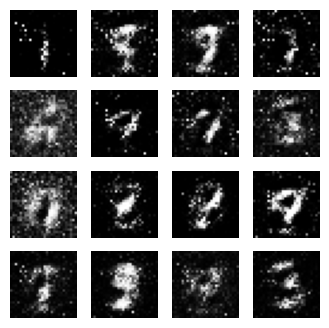

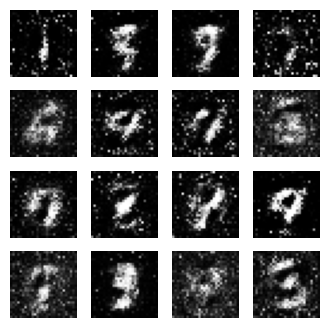

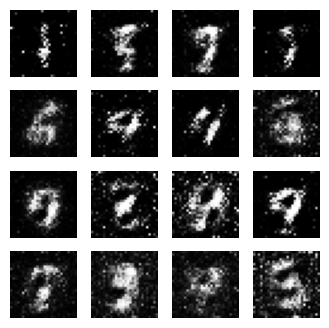

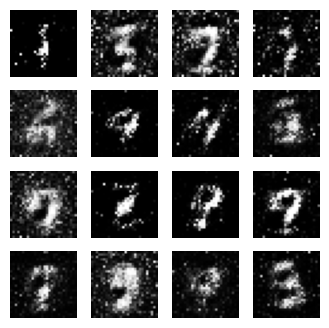

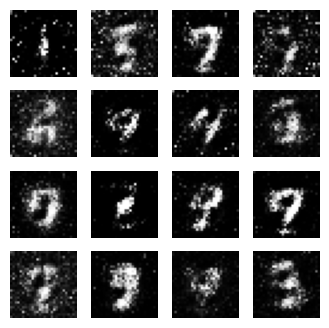

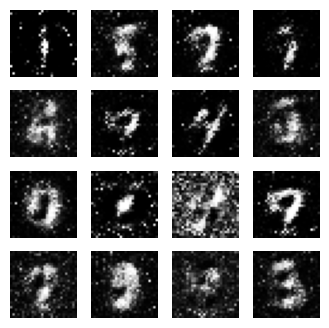

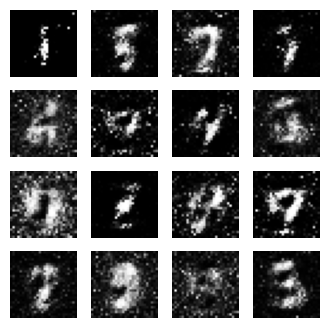

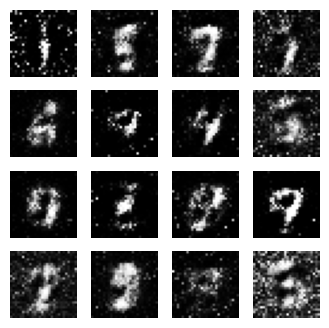

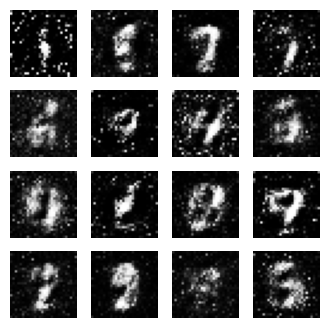

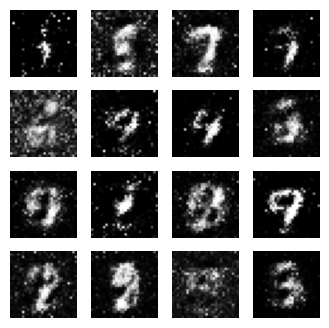

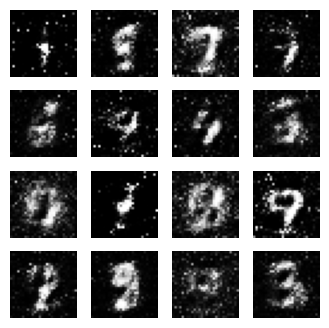

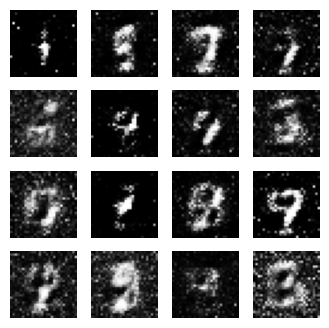

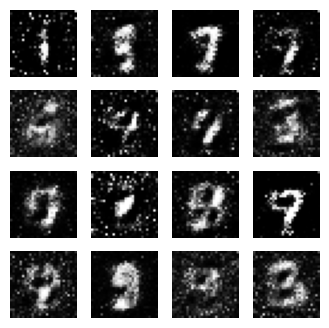

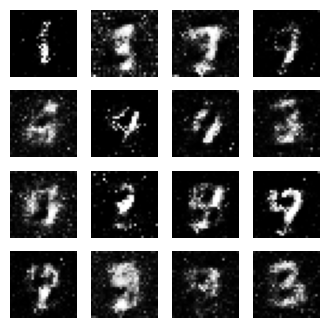

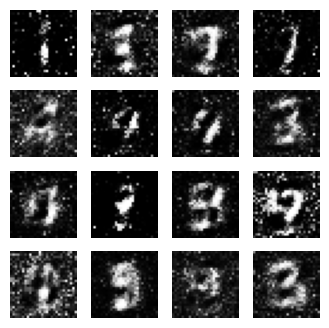

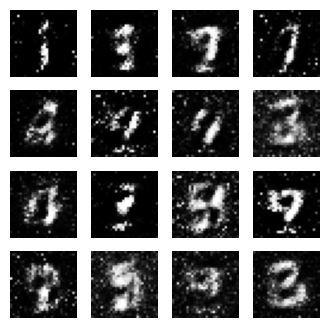

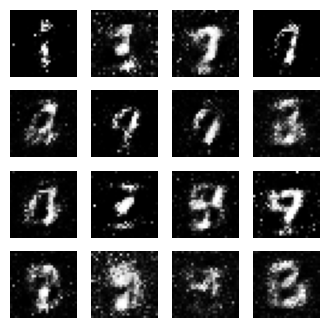

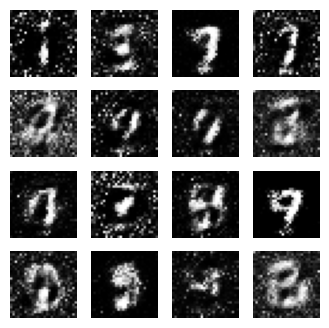

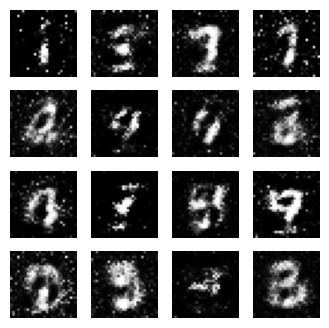

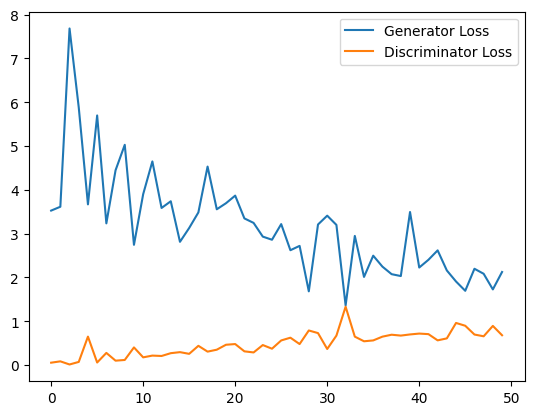

In [7]:
# Load MNIST data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Initialize the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the number of epochs to train
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Define the fixed seed for generating images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Define the arrays to store losses
gen_loss_arr = []
disc_loss_arr = []

# Define the training loop
for epoch in range(EPOCHS):
    for images in train_dataset:
        train_step(images)

    # Generate and save images
    generated_images = generator(seed, training=False)

    # Save the loss for each epoch
    gen_loss_arr.append(float(generator_loss(discriminator(generated_images, training=False))))
    disc_loss_arr.append(float(discriminator_loss(discriminator(images, training=False), discriminator(generated_images, training=False))))

    # Plot generated images
    fig = plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((generated_images[i, :, :, 0] + 1) / 2, cmap='gray')
        plt.axis('off')
    plt.show()

# Plot the generator and discriminator loss over time
plt.plot(gen_loss_arr, label='Generator Loss')
plt.plot(disc_loss_arr, label='Discriminator Loss')
plt.legend()
plt.show()